In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr

In [4]:
# import data
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

In [5]:
stocklist = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stocklist]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)
meanReturns, covMatrix = get_data(stocks, startDate, endDate)
print(meanReturns)

[*********************100%%**********************]  6 of 6 completed

Ticker
BHP.AX   -0.000067
CBA.AX    0.000614
NAB.AX    0.000907
STO.AX   -0.000087
TLS.AX   -0.000978
WBC.AX    0.000901
dtype: float64


In [6]:
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)
print(weights)

[0.25292024 0.01069989 0.21802688 0.2426558  0.0615214  0.21417579]


In [16]:
def mcVaR(returns, alpha=5):
    """
        Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

In [20]:
def mcCVaR(returns, alpha=5):
    """
        Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVar(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [18]:
# Monte Carlo simulations
mc_sims = 100
T = 100 # timeframe in days

meanM = np.full(shape=(T,len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

In [21]:
portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR, 2)))
print('CVaR ${}'.format(round(CVaR, 2)))

VaR $1136.37
CVaR $1499.53


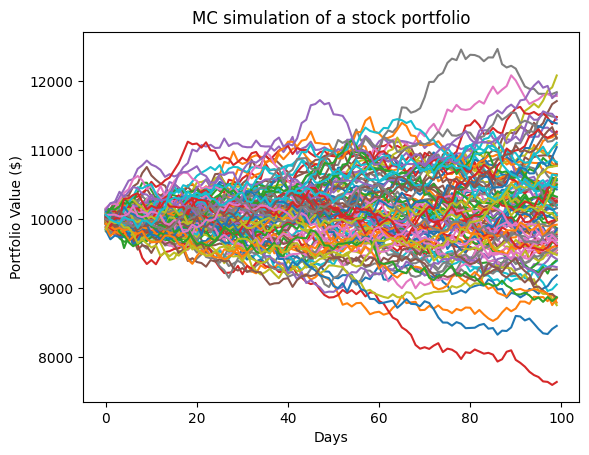

In [22]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()